In [66]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [67]:
import os

os.chdir('/content/gdrive/My Drive/CODE-MIXED-SENTI')
os.getcwd()

'/content/gdrive/My Drive/CODE-MIXED-SENTI'

In [68]:
!pip install tweet-preprocessor

In [69]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter


import preprocessor as p
# p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
# p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.SMILEY, p.OPT.NUMBER)

cleaning = False

In [70]:
from imblearn.pipeline import Pipeline
from scipy.sparse import hstack, vstack

In [71]:
train_data=pd.read_csv("data/malayalam_train.tsv",encoding='utf-8',sep='\t')
dev_data=pd.read_csv("data/malayalam_dev.tsv",encoding='utf-8',sep='\t')

In [72]:
train_data['text']=train_data['text'].str.title()
dev_data['text']=dev_data['text'].str.title()

In [73]:
if cleaning:
  text_ = pd.concat([train_data['text'], dev_data['text']])
  label_ = pd.concat([train_data['category'], dev_data['category']])
  text_ = text_.apply(lambda x: p.clean(x))
else:
  text_ = pd.concat([train_data['text'], dev_data['text']])
  label_ = pd.concat([train_data['category'], dev_data['category']])


Counter({'Positive ': 2246, 'unknown_state ': 1505, 'not-malayalam ': 707, 'Negative ': 600, 'Mixed_feelings ': 333})


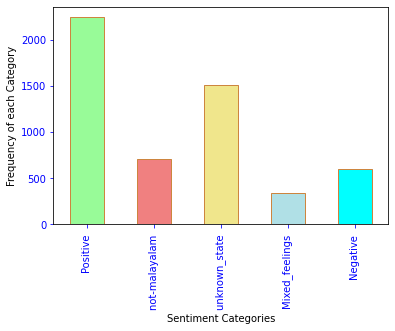

<Figure size 432x288 with 0 Axes>

In [74]:
counter = Counter(label_)
print(counter)

plt.ylabel('Frequency of each Category')
plt.xlabel('Sentiment Categories')

s = pd.Series(list(counter.values()), index = list(counter.keys()) )

ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='blue')

s.plot.bar(color=['palegreen', 'lightcoral', 'khaki', 'powderblue', 'cyan'], edgecolor='peru')
# plt.show()
plt.savefig('Malayalam_class.jpg', dpi=300)
plt.plot()

In [75]:

word_vectorizer = CountVectorizer(
    #sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    max_features=1000)

char_vectorizer = CountVectorizer(
    #sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=30000
    )


In [76]:
# build Vocabulary and Transform raw input to features
word_vectorizer.fit(text_)
char_vectorizer.fit(text_)

# word_vectorizer.fit(all_text)
# char_vectorizer.fit(all_text)


def feature_conversion(trainX):
  train_word_feat = word_vectorizer.transform(trainX)
  train_char_feat = char_vectorizer.transform(trainX)
  return hstack([train_word_feat, train_char_feat])


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                 precision    recall  f1-score   support

Mixed_feelings      0.6000    0.3529    0.4444        34
      Negative      0.6364    0.5600    0.5957        50
      Positive      0.7583    0.7778    0.7679       234
 not-malayalam      0.7284    0.7564    0.7421        78
 unknown_state      0.6258    0.6736    0.6488       144

       accuracy                         0.7000       540
      macro avg     0.6698    0.6241    0.6398       540
   weighted avg     0.6974    0.7000    0.6961       540

0.7
[[ 12   2  11   1   8]
 [  3  28   7   0  12]
 [  3   8 182  14  27]
 [  0   0   8  59  11]
 [  2   6  32   7  97]]


[]

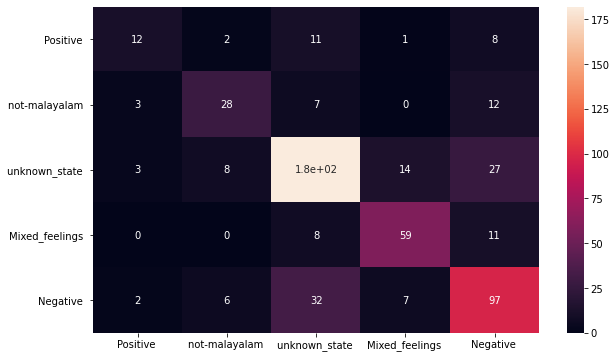

In [77]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split


# X_train = train_text
# X_test = dev_text

# y_train = train_label
# y_test = dev_label

X_train = feature_conversion(text_)

def Classifier():
  steps = [('under',TomekLinks()),('model',LogisticRegression())]
  pipeline = Pipeline(steps=steps)
  return pipeline

train_x, dev_x, train_y, dev_y = train_test_split(X_train, label_, test_size=0.1, shuffle=True)

classifier = Classifier()
classifier.fit(train_x, train_y)

dev_predict = classifier.predict(dev_x)

cm = confusion_matrix(dev_y, dev_predict)
print(classification_report(dev_y, dev_predict, digits=4))
print(accuracy_score(dev_y, dev_predict))
print(cm)

columns = index = label_.unique()
cm_df = pd.DataFrame(cm, columns, index)                  
plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True)
plt.savefig('heatmap.jpg')
plt.plot()


# ** *This cell is testing cell, used for applying stratified cross validation to avoid imbalancing issues.* **

In [78]:
# #

# from sklearn.model_selection import StratifiedKFold
# from sklearn import preprocessing
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import cross_validate
# from imblearn.under_sampling import TomekLinks
# le = preprocessing.LabelEncoder()

# x_data, y_data = train_text.to_list()+dev_text.to_list(), train_label.to_list()+dev_label.to_list()
# x_idx = [idx for idx, _ in enumerate(x_data)]
# le.fit(y_data)
# y_idx = le.transform(y_data)

# skf = StratifiedKFold(n_splits=10)


# for train_index, test_index in skf.split(x_idx, y_idx):
#   X_train = [x_data[x_idx[idx]] for idx in train_index]
#   X_test = [x_data[x_idx[idx]] for idx in test_index]

#   y_train = [list(le.inverse_transform([y_idx[idx]]))[0] for idx in train_index]
#   y_test = [list(le.inverse_transform([y_idx[idx]]))[0] for idx in test_index]

#   train_word_feat = word_vectorizer.transform(X_train)
#   train_char_feat = char_vectorizer.transform(X_train)

#   test_word_feat = word_vectorizer.transform(X_test)
#   test_char_feat = char_vectorizer.transform(X_test)

#   X_train = hstack([train_word_feat, train_char_feat])
#   X_test = hstack([test_word_feat, test_char_feat])

#   # steps = [('under',TomekLinks()),('model',LogisticRegression(class_weight='balanced'))]
#   steps = [('under',TomekLinks()),('model',LogisticRegression())]
#   pipeline = Pipeline(steps=steps)
#   #lr.fit(X_train, y_train)

#   #dev_predict = lr.predict(X_test)
#   pipeline = Pipeline(steps=steps)
#   pipeline.fit(X_train, y_train)
#   dev_predict = pipeline.predict(X_test)

   
#   cm = confusion_matrix(y_test, dev_predict)
#   print(cm)
#   # columns = index = train_label.unique()

#    #cm_df = pd.DataFrame(cm, columns, index)                  
#    #plt.figure(figsize=(10,6))
#    #sns.heatmap(cm_df, annot=True)
#   # plt.savefig('heatmap.jpg')
#     #plt.plot()
#   print(classification_report(y_test, dev_predict, digits=4))
#   print(accuracy_score(y_test, dev_predict))


In [79]:
test_data = pd.read_csv('data/malayalam_test.csv', encoding='utf-8', sep=',')

test_data.columns
test_id = test_data['id']
test_text = test_data['text']

if cleaning:
  test_text = test_text.apply(lambda x: p.clean(x))
  test_feat = feature_conversion(test_text)
else:
  test_feat = feature_conversion(test_text)

test_pred_label = classifier.predict(test_feat)
test_label = pd.DataFrame(test_pred_label, index=None, columns=['label'])
pd.concat([test_id, test_data['text'], test_label], axis=1).to_csv('malayalam_test_pred.tsv', sep='\t', index=False)


In [80]:
print(test_pred_label[:10])

['unknown_state ' 'unknown_state ' 'unknown_state ' 'unknown_state '
 'Positive ' 'unknown_state ' 'unknown_state ' 'Negative ' 'Positive '
 'Negative ']
